<div>
<img src="https://res-5.cloudinary.com/crunchbase-production/image/upload/c_lpad,h_256,w_256,f_auto,q_auto:eco/v1455514364/pim02bzqvgz0hibsra41.png" align="right"><br><br><FONT FACE="times new roman" SIZE=5>
<b></b>
<br>
<i><b>Docente:</b></i> Camilo Rodriguez.
<br>
<i><b>Asignatura:</b></i> Semillero de investigación
<br>
<i><b>Estudiante:</b></i> Esteban Rodriguez, Laura Gomez y Santiago Niño
<br>
<i><b>Tema:</b></i> TrabajoSemilleroInvestigacion_Taxis
<br>
<br> Agosto/2023
<br>
</FONT>
</div>

#**Importación de librerias**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import time
from numba import jit
import humanize
import math
from tqdm import tqdm
from ydata_profiling import ProfileReport
from geopy.geocoders import Nominatim

C:\Users\Laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\Laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\visions\backends\shared\nan_handling.py:50: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for de

#**1. Recopilar y preparar los datos**

In [3]:
zip_file_path = "d:/taxis/geojson/semilleroInvestigacion_Taxis/Dataset/SERVICIO_UNIFICADO_2023.parquet"

In [4]:
df = pd.read_parquet(zip_file_path)

In [5]:
df.head(1)

,ID,CITY,USER,LATITUDEORI,LATITUDEDEST,LONGITUDEORI,LONGITUDEDEST,STATUS,CHANNEL,COMPLETEDATE,DATE,DAYOFWEEK,HOUR,MONTH
0,80206465,11001,8168434.0,4.646835,4.669337,-74.101619,-74.111349,CANCELADO,APP,2022-10-01 00:00:00,2022-10-01,6,0,10


#**2. Exploración y limpieza de los datos**

##**Preprocesamiento:**
* Se verifica si se presentan datos no disponibles o NaN para eliminarlos.
* Se eliminan las variables que no se usarán en el desarrollo.
*Se convierte los datos de tipo objeto al tipo de dato que si corresponda.

In [6]:
#Se separa solo los datos de Bogotá
bogota = df[df['CITY'] == 11001]

In [7]:
bogota.shape

(14870616, 14)

In [8]:
print("Número de registro en la ciudad de bogotá: ",bogota.shape[0])

Número de registro en la ciudad de bogotá:  14870616


In [9]:
print("Número de datos NaN por categoria: ", bogota.isnull().sum())

Número de datos NaN por categoria:  ID                     0
CITY                   0
USER                  91
LATITUDEORI            0
LATITUDEDEST     2812968
LONGITUDEORI           0
LONGITUDEDEST    2812968
STATUS                 0
CHANNEL                0
COMPLETEDATE           0
DATE                   0
DAYOFWEEK              0
HOUR                   0
MONTH                  0
dtype: int64


In [10]:
#Se eliminan los datos NaN
df_bogota = bogota.dropna()

In [11]:
print("Número de datos NaN por categoria, después de eliminar las filas que contenian NaN: ", df_bogota.isnull().sum())

Número de datos NaN por categoria, después de eliminar las filas que contenian NaN:  ID               0
CITY             0
USER             0
LATITUDEORI      0
LATITUDEDEST     0
LONGITUDEORI     0
LONGITUDEDEST    0
STATUS           0
CHANNEL          0
COMPLETEDATE     0
DATE             0
DAYOFWEEK        0
HOUR             0
MONTH            0
dtype: int64


In [12]:
#Se verifica el número de datos resultantes
df_bogota.shape[0]

12057629

In [13]:
type(df_bogota['DATE'])

pandas.core.series.Series

In [14]:
df_bogota['COMPLETEDATE'] = pd.to_datetime(df_bogota['COMPLETEDATE'])

C:\Users\Laura\AppData\Local\Temp\ipykernel_5652\2592436540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bogota['COMPLETEDATE'] = pd.to_datetime(df_bogota['COMPLETEDATE'])


#**3. Análisis Estadístico**

In [15]:
df_bogota['COMPLETEDATE'][0]

Timestamp('2022-10-01 00:00:00')

In [16]:
#Columnas a eliminar
valores_a_eliminar = ['ABORDOCONFIRMADO', 'CONFIRMADO', 'FINALIZADO', 'ALFRENTE', 'NUEVO', 'RECHAZADO', 'ASIGNADO']

In [17]:
# Filtrar los registros que no contienen los valores en la columna 'STATUS'
df_bogota = df_bogota[~df_bogota['STATUS'].isin(valores_a_eliminar)]

In [18]:
valores_a_eliminar =['EXTERNO','CALLE','WEB','Reserva','CHAT_BOT_803','CHAT_BOT_689','IONTAXI','Kiosko #1']

In [19]:
# Filtrar los registros que no contienen los valores en la columna 'STATUS'
df_bogota = df_bogota[~df_bogota['CHANNEL'].isin(valores_a_eliminar)]

In [20]:
df_bogota.shape

(12005856, 14)

In [21]:
print(df_bogota.COMPLETEDATE.min())
print(df_bogota.COMPLETEDATE.max())


2022-10-01 00:00:00
2023-04-20 13:25:47


Solo se tiene registro desde el primero de octubre de 2022
hasta el 20 de abril del 2023, es decir que solo se tiene registro de 7 meses

In [22]:
df_bogota['MONTH'].unique()

array([10, 11, 12,  1,  2,  3,  4], dtype=int64)

In [23]:
df_bogota['DAYOFWEEK'].unique()

array([6, 7, 1, 2, 3, 4, 5], dtype=int64)

In [24]:
df_bogota['YEAR']  = df_bogota['COMPLETEDATE'].dt.year

In [25]:
df_bogota['COMPLETEHOUR'] = df_bogota['COMPLETEDATE'].dt.strftime('%H:%M:%S')

In [26]:
df_bogota.groupby(['STATUS','YEAR'])[['COMPLETEDATE']].describe()


COMPLETEDATE                                 \
                       count                           mean   
STATUS     YEAR                                               
ABANDONADO 2022      4744748  2022-11-21 06:23:10.104971264   
           2023      2653892  2023-02-20 10:53:56.086432256   
CANCELADO  2022       737406  2022-11-16 22:41:27.456223744   
           2023       618080  2023-02-24 15:35:07.148538624   
CUMPLIDO   2022      1561670  2022-11-15 09:29:17.243770880   
           2023      1690060  2023-02-24 16:40:00.000154368   

                                                                     \
                                 min                            25%   
STATUS     YEAR                                                       
ABANDONADO 2022  2022-10-01 00:00:00  2022-10-31 11:12:32.750000128   
           2023  2023-01-01 00:00:00            2023-01-27 12:06:49   
CANCELADO  2022  2022-10-01 00:00:00  2022-10-25 23:52:55.249999872   
           2023  2023-01-01 00:00:02     2023-01-31 12:05:51.500000   
CUMPLIDO   2022  2022-10-01 00:00:00     2022-10-23 08:33:56.500000   
           2023  2023-01-01 00:00:07            2023-01-31 00:16:59   

                                                                     \
                                 50%                            75%   
STATUS     YEAR                                                       
ABANDONADO 2022  2022-11-26 01:16:55  2022-12-14 03:08:15.249999872   
           2023  2023-02-21 12:56:36            2023-03-12 22:41:22   
CANCELADO  2022  2022-11-18 03:46:24     2022-12-09 12:20:39.500000   
           2023  2023-02-26 00:37:40     2023-03-20 03:32:24.500000   
CUMPLIDO   2022  2022-11-15 22:48:55     2022-12-07 18:21:51.500000   
           2023  2023-02-25 03:28:58     2023-03-21 14:15:05.500000   

                                      
                                 max  
STATUS     YEAR                       
ABANDONADO 2022  2022-12-31 23:59:59  
           2023  2023-04-20 13:25:47  
CANCELADO  2022  2022-12-31 23:59:57  
           2023  2023-04-20 13:25:01  
CUMPLIDO   2022  2022-12-31 23:59:56  
           2023  2023-04-20 13:21:20

In [27]:
df_bogota.groupby(['STATUS','MONTH','YEAR'])[['COMPLETEDATE']].describe()

COMPLETEDATE                                 \
                             count                           mean   
STATUS     MONTH YEAR                                               
ABANDONADO 1     2023       754286  2023-01-16 05:13:38.028220160   
           2     2023       763134  2023-02-12 21:32:27.797082624   
           3     2023       872889  2023-03-13 17:29:35.355523072   
           4     2023       263583  2023-04-13 17:06:06.511394816   
           10    2022      1243165  2022-10-18 17:20:44.615780096   
           11    2022      1440816  2022-11-16 03:33:30.638877440   
           12    2022      2060767  2022-12-15 01:54:23.020004096   
CANCELADO  1     2023       158422  2023-01-17 06:45:55.823496704   
           2     2023       172440  2023-02-14 09:05:58.406042624   
           3     2023       197596  2023-03-15 12:43:58.776280832   
           4     2023        89622  2023-04-11 14:27:40.763238912   
           10    2022       243757  2022-10-17 08:49:35.378434304   
           11    2022       225372  2022-11-16 02:36:39.367809792   
           12    2022       268277  2022-12-15 10:21:01.069350400   
CUMPLIDO   1     2023       439589  2023-01-17 09:29:43.857457664   
           2     2023       481018  2023-02-15 00:03:37.753448448   
           3     2023       516813  2023-03-15 23:31:11.680846080   
           4     2023       252640  2023-04-11 08:02:46.706075392   
           10    2022       541044  2022-10-16 13:20:15.603097088   
           11    2022       509341  2022-11-16 07:24:34.873410304   
           12    2022       511285  2022-12-16 01:29:00.316690432   

                                                                           \
                                       min                            25%   
STATUS     MONTH YEAR                                                       
ABANDONADO 1     2023  2023-01-01 00:00:00     2023-01-10 17:04:30.500000   
           2     2023  2023-02-01 00:00:01  2023-02-03 12:49:54.249999872   
           3     2023  2023-03-01 00:00:02            2023-03-07 22:12:20   
           4     2023  2023-04-01 00:00:00            2023-04-10 11:58:45   
           10    2022  2022-10-01 00:00:00            2022-10-08 22:22:27   
           11    2022  2022-11-01 00:00:00            2022-11-08 11:38:53   
           12    2022  2022-12-01 00:00:00     2022-12-07 04:03:12.500000   
CANCELADO  1     2023  2023-01-01 00:00:02     2023-01-10 22:00:43.500000   
           2     2023  2023-02-01 00:00:03            2023-02-05 17:27:17   
           3     2023  2023-03-01 00:00:02  2023-03-08 00:53:32.750000128   
           4     2023  2023-04-01 00:00:02     2023-04-05 19:37:44.500000   
           10    2022  2022-10-01 00:00:00            2022-10-08 16:19:57   
           11    2022  2022-11-01 00:00:02     2022-11-08 12:59:27.500000   
           12    2022  2022-12-01 00:00:03            2022-12-07 18:22:35   
CUMPLIDO   1     2023  2023-01-01 00:00:07            2023-01-10 18:38:52   
           2     2023  2023-02-01 00:00:03            2023-02-07 11:52:11   
           3     2023  2023-03-01 00:00:01            2023-03-08 05:25:43   
           4     2023  2023-04-01 00:00:00  2023-04-05 16:29:55.750000128   
           10    2022  2022-10-01 00:00:00     2022-10-08 09:47:43.500000   
           11    2022  2022-11-01 00:00:12            2022-11-08 21:50:05   
           12    2022  2022-12-01 00:00:01            2022-12-08 04:07:01   

                                                   \
                                              50%   
STATUS     MONTH YEAR                               
ABANDONADO 1     2023         2023-01-17 14:57:06   
           2     2023         2023-02-10 11:47:59   
           3     2023         2023-03-11 17:12:52   
           4     2023         2023-04-16 01:23:31   
           10    2022         2022-10-20 10:22:44   
           11    2022         2022-11-16 17:06:10   
           12    2022         2022-12-1

ABANDONADO:  El mes que tuvo mayor cantidad de abandonos fue el mes  12(Diciembre) 2022 == 2.1 millones
ABANDONADO:  El mes que tuvo menor cantidad de abandonos fue el mes  4(abril) 2023 == 263.6 mil

CANCELADO:  El mes que tuvo mayor cantidad de cancelaciones fue el mes 12(Diciembre) 2022 == 268.3 mil
CANCELADO:  El mes que tuvo menor cantidad de cancelaciones fue el mes 4(abril) 2023 == 89.6 mil

CUMPLIDO:  El mes que tuvo mayor cantidad de viajes completados fue el mes 10(Octubre) 2022 == 541 mil
CUMPLIDO:  El mes que tuvo menor cantidad de viajes completados fue el mes 4(abril) 2023 == 252.6 mil

In [28]:
df_bogota.groupby(['CHANNEL','YEAR'])[['COMPLETEDATE']].describe()

COMPLETEDATE                                 \
                         count                           mean   
CHANNEL      YEAR                                               
APP          2022      6736874  2022-11-19 18:14:29.537518336   
             2023      4618289  2023-02-22 03:58:55.974063872   
CHAT_BOT_659 2022        86051  2022-11-15 22:33:29.509930240   
             2023       104154  2023-02-25 10:56:19.226904320   
IVR          2022       177547  2022-11-13 19:25:41.190946560   
             2023       194031  2023-02-26 08:21:49.305317632   
RECEPCION    2022        43352  2022-11-11 10:29:01.505766656   
             2023        45558  2023-02-24 14:33:17.606852864   

                                                                       \
                                   min                            25%   
CHANNEL      YEAR                                                       
APP          2022  2022-10-01 00:00:00            2022-10-29 01:11:41   
             2023  2023-01-01 00:00:00            2023-01-29 00:11:50   
CHAT_BOT_659 2022  2022-10-01 00:00:08            2022-10-24 21:40:20   
             2023  2023-01-01 00:01:26  2023-01-31 13:02:57.750000128   
IVR          2022  2022-10-01 00:11:07            2022-10-21 14:08:52   
             2023  2023-01-01 00:01:24     2023-01-31 13:28:48.500000   
RECEPCION    2022  2022-10-01 00:01:59  2022-10-19 19:47:16.750000128   
             2023  2023-01-01 00:28:45     2023-01-28 05:19:26.500000   

                                                                              \
                                          50%                            75%   
CHANNEL      YEAR                                                              
APP          2022  2022-11-23 14:58:41.500000            2022-12-12 13:25:54   
             2023         2023-02-23 11:03:02            2023-03-15 20:33:24   
CHAT_BOT_659 2022         2022-11-16 20:36:03            2022-12-07 18:55:51   
             2023         2023-02-26 01:28:52  2023-03-22 20:04:39.249999872   
IVR          2022         2022-11-13 12:55:02     2022-12-05 14:32:35.500000   
             2023         2023-02-27 16:14:24     2023-03-24 12:13:44.500000   
RECEPCION    2022         2022-11-09 20:13:33  2022-12-02 12:39:21.750000128   
             2023  2023-02-24 17:59:11.500000            2023-03-22 20:20:26   

                                        
                                   max  
CHANNEL      YEAR                       
APP          2022  2022-12-31 23:59:59  
             2023  2023-04-20 13:25:47  
CHAT_BOT_659 2022  2022-12-31 23:58:01  
             2023  2023-04-20 13:15:23  
IVR          2022  2022-12-31 23:57:03  
             2023  2023-04-20 13:12:30  
RECEPCION    2022  2022-12-31 23:53:20  
             2023  2023-04-20 13:09:31

In [29]:
df_bogota.groupby(['CHANNEL','MONTH','YEAR'])[['COMPLETEDATE']].describe()

COMPLETEDATE                                 \
                               count                           mean   
CHANNEL      MONTH YEAR                                               
APP          1     2023      1263159  2023-01-16 16:16:03.101539840   
             2     2023      1323587  2023-02-13 16:19:48.111108864   
             3     2023      1483226  2023-03-14 13:27:27.152797440   
             4     2023       548317  2023-04-12 12:54:33.973048576   
             10    2022      1917411  2022-10-18 01:55:52.070116096   
             11    2022      2071358  2022-11-16 04:08:17.261335296   
             12    2022      2748105  2022-12-15 06:22:16.065808384   
CHAT_BOT_659 1     2023        26594  2023-01-17 14:45:09.945401088   
             2     2023        29312  2023-02-15 01:39:20.300150016   
             3     2023        31719  2023-03-16 06:53:50.429742336   
             4     2023        16529  2023-04-11 05:31:34.814689280   
             10    2022        28355  2022-10-16 12:57:46.930417920   
             11    2022        29483  2022-11-16 11:08:36.939117568   
             12    2022        28213  2022-12-15 22:40:24.917981184   
IVR          1     2023        49471  2023-01-17 03:14:41.495765248   
             2     2023        52262  2023-02-15 18:04:07.628430080   
             3     2023        58782  2023-03-16 14:17:25.648123648   
             4     2023        33516  2023-04-11 05:23:14.763635200   
             10    2022        64607  2022-10-16 03:41:06.438141440   
             11    2022        60545  2022-11-16 10:00:58.502436096   
             12    2022        52395  2022-12-16 03:08:36.885771776   
RECEPCION    1     2023        13073  2023-01-17 22:58:35.404038912   
             2     2023        11431  2023-02-14 13:18:49.275828992   
             3     2023        13571  2023-03-16 09:02:06.313094144   
             4     2023         7483  2023-04-10 21:08:34.278898944   
             10    2022        17593  2022-10-16 06:12:50.281703168   
             11    2022        14143  2022-11-15 22:48:24.114827264   
             12    2022        11616     2022-12-15 14:08:27.687328   

                                                                             \
                                         min                            25%   
CHANNEL      MONTH YEAR                                                       
APP          1     2023  2023-01-01 00:00:00     2023-01-10 19:02:05.500000   
             2     2023  2023-02-01 00:00:01     2023-02-04 03:06:52.500000   
             3     2023  2023-03-01 00:00:01  2023-03-07 22:50:58.249999872   
             4     2023  2023-04-01 00:00:00            2023-04-06 03:43:01   
             10    2022  2022-10-01 00:00:00     2022-10-08 18:54:06.500000   
             11    2022  2022-11-01 00:00:00            2022-11-08 12:18:34   
             12    2022  2022-12-01 00:00:00            2022-12-07 11:39:36   
CHAT_BOT_659 1     2023  2023-01-01 00:01:26     2023-01-10 22:53:33.500000   
             2     2023  2023-02-01 00:00:03     2023-02-07 12:58:08.500000   
             3     2023  2023-03-01 00:00:22     2023-03-08 12:28:17.500000   
             4     2023  2023-04-01 00:01:19            2023-04-05 13:31:30   
             10    2022  2022-10-01 00:00:08     2022-10-08 00:42:54.500000   
             11    2022  2022-11-01 00:06:11     2022-11-09 03:07:00.500000   
             12    2022  2022-12-01 00:00:14            2022-12-08 04:56:07   
IVR          1     2023  2023-01-01 00:01:24            2023-01-10 10:19:45   
             2     2023  2023-02-01 00:10:22            2023-02-08 13:50:08   
             3     2023  2023-03-01 00:02:02  2023-03-08 15:16:19.750000128   
             4     2023  2023-04-01 00:03:05            2023-04-05 14:41:12   
             10    2022  2022-10-01 00:11:07     2022-10-08 11:19:40.500000   
             11    2022  2022-11-01 00:12:42            2022-11-09 09:10:53   
     

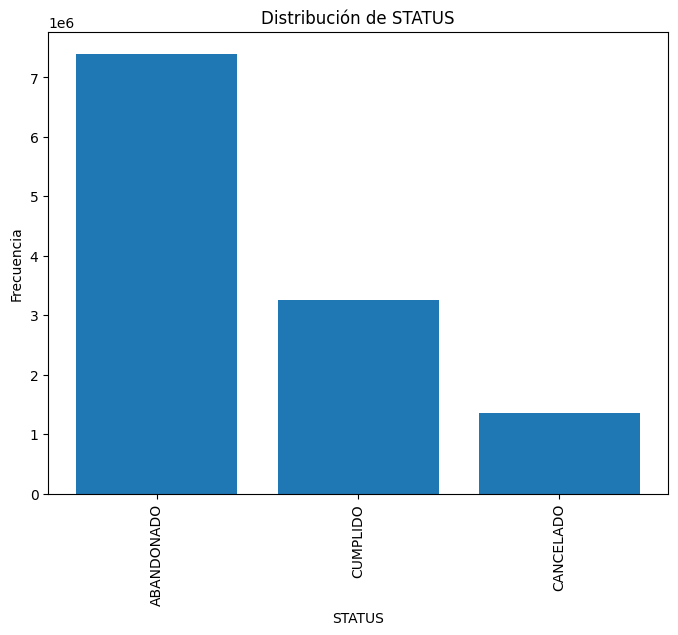

In [30]:
# Obtener la frecuencia de valores para la columna 'STATUS'
status_counts = df_bogota['STATUS'].value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(status_counts.index, status_counts.values)
plt.title("Distribución de STATUS")
plt.xlabel("STATUS")
plt.ylabel("Frecuencia")
plt.xticks(rotation=90)
plt.show()

#**4. Mapas**

In [31]:
#pandas_df = df_bogota[['LATITUDEORI', 'LONGITUDEORI', 'LATITUDEDEST', 'LONGITUDEDEST']]

In [32]:
# Coordenadas de Bogotá como punto de inicio
mapa1 = folium.Map(location=[4.6097, -74.0817], zoom_start=12)

El método reverse() de Geopy se utiliza para obtener información sobre una ubicación específica a partir de sus coordenadas de latitud y longitud. Cuando proporcionas un par de coordenadas (latitud y longitud) al método reverse(), Geopy consulta un servicio de geocodificación (en este caso, Nominatim) para recuperar detalles sobre esa ubicación, como la dirección, el código postal, la ciudad, el país, etc.

las upz son:
UNIDADES DE PLANEAMIENTO ZONAL - UPZ
Unidades de Planeamiento Zonas UPZ, las cuales se pueden definir como territorios que concentran algunos barrios dentro de las localidades y permiten planificar el desarrollo urbano en un nivel zonal.

In [33]:
df_bogota.head(3)

,ID,CITY,USER,LATITUDEORI,LATITUDEDEST,LONGITUDEORI,LONGITUDEDEST,STATUS,CHANNEL,COMPLETEDATE,DATE,DAYOFWEEK,HOUR,MONTH,YEAR,COMPLETEHOUR
0,80206465,11001,8168434.0,4.646835,4.669337,-74.101619,-74.111349,CANCELADO,APP,2022-10-01,2022-10-01,6,0,10,2022,00:00:00
2,80206467,11001,10186684.0,4.607889,4.547080,-74.078844,-74.148150,ABANDONADO,APP,2022-10-01,2022-10-01,6,0,10,2022,00:00:00
5,80206470,11001,8318357.0,4.603996,4.641825,-74.129169,-74.153460,ABANDONADO,APP,2022-10-01,2022-10-01,6,0,10,2022,00:00:00


In [34]:
user_agent = "my_geocoding_app/1.0"
geolocator = Nominatim(user_agent=user_agent)
ubication = geolocator.reverse(("4.646834566745485", "-74.10161945968866"))
print(ubication.address)
print(ubication.raw.keys())
print(ubication.raw)

Gran Estación, Calle 24A, Salitre Oriental, UPZs Localidad Teusaquillo, Localidad Teusaquillo, Bogotá, Bogotá, Distrito Capital, RAP (Especial) Central, 111321, Colombia
dict_keys(['place_id', 'licence', 'osm_type', 'osm_id', 'lat', 'lon', 'class', 'type', 'place_rank', 'importance', 'addresstype', 'name', 'display_name', 'address', 'boundingbox'])
{'place_id': 298388979, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 35957432, 'lat': '4.6475574', 'lon': '-74.10144278249399', 'class': 'shop', 'type': 'mall', 'place_rank': 30, 'importance': 0.17461773632832445, 'addresstype': 'shop', 'name': 'Gran Estación', 'display_name': 'Gran Estación, Calle 24A, Salitre Oriental, UPZs Localidad Teusaquillo, Localidad Teusaquillo, Bogotá, Bogotá, Distrito Capital, RAP (Especial) Central, 111321, Colombia', 'address': {'shop': 'Gran Estación', 'road': 'Calle 24A', 'neighbourhood': 'Salitre Oriental', 'quarter': 'UPZs Localidad Teusaqui

In [35]:
# Reverse es para que nos traiga la información de ese punto geografico
ubicacion = geolocator.reverse(("4.646834566745485", "-74.10161945968866"))

#Cuando se usa raw directamente es porque es un atributo de la información que por defecto tiene la consulta geografica
direccion = ubicacion.raw.get('address', {})
nombre_tipo_clase = ubicacion.raw.get('class', 'N/A')
nombre_tipo_lugar = ubicacion.raw.get('type', 'N/A')

# Obtiene el nombre del barrio, la UPZ y la localidad
# a diferencia de usar directamente el raw es porque estas consultas vienen de un subconjunto de datos de la información extraida
nombre_barrio = direccion.get('neighbourhood', 'N/A')
upz = direccion.get('quarter', 'N/A')
localidad = direccion.get('suburb', 'N/A')

# Imprime la información extraída
print("clase de lugar: ", nombre_tipo_clase)
print("Tipo de lugar: ", nombre_tipo_lugar)
print("Nombre del Barrio:", nombre_barrio)
print("UPZ:", upz)
print("Localidad:", localidad)


clase de lugar:  shop
Tipo de lugar:  mall
Nombre del Barrio: Salitre Oriental
UPZ: UPZs Localidad Teusaquillo
Localidad: Localidad Teusaquillo


In [36]:
df_bogota_origen = df_bogota.copy()
df_bogota_destinos = df_bogota.copy()

In [37]:
df_bogota.columns

Index(['ID', 'CITY', 'USER', 'LATITUDEORI', 'LATITUDEDEST', 'LONGITUDEORI',
       'LONGITUDEDEST', 'STATUS', 'CHANNEL', 'COMPLETEDATE', 'DATE',
       'DAYOFWEEK', 'HOUR', 'MONTH', 'YEAR', 'COMPLETEHOUR'],
      dtype='object')

In [38]:
df_bogota_origen.drop(columns = ['LATITUDEDEST','LONGITUDEDEST'], inplace = True)
df_bogota_destinos.drop(columns = ['LATITUDEORI','LONGITUDEORI'], inplace = True)

In [39]:
df_bogota_origen.shape

(12005856, 14)

In [40]:
df_bogota_origen.rename(columns={'LATITUDEORI':'LATITUD',
                                'LONGITUDEORI':'LONGITUD'}, 
                        inplace = True)

df_bogota_destinos.rename(columns={'LATITUDEDEST':'LATITUD',
                                'LONGITUDEDEST':'LONGITUD'}, 
                        inplace = True)

In [41]:
print(df_bogota_origen.shape)
print(df_bogota_destinos.shape)

(12005856, 14)
(12005856, 14)


In [42]:
df_bogota_origen.head(1)

,ID,CITY,USER,LATITUD,LONGITUD,STATUS,CHANNEL,COMPLETEDATE,DATE,DAYOFWEEK,HOUR,MONTH,YEAR,COMPLETEHOUR
0,80206465,11001,8168434.0,4.646835,-74.101619,CANCELADO,APP,2022-10-01,2022-10-01,6,0,10,2022,00:00:00


In [50]:
def agregar_localidades(df):
    geolocator = Nominatim(user_agent="my_geocoder")
    data = [] 

    batch_size = 1000
    num_batches = len(df) // batch_size + 1

    for batch_num in tqdm(range(num_batches), desc="Procesando lotes"):
        start_idx = batch_num * batch_size
        end_idx = (batch_num + 1) * batch_size
        batch_df = df.iloc[start_idx:end_idx]

        for index, row in tqdm(batch_df.iterrows(), total=len(batch_df), desc=f"Lote {batch_num}", leave=False):
            latitud = row['LATITUD']
            longitud = row['LONGITUD']

            try:
                ubicacion = geolocator.reverse((latitud, longitud))
                direccion = ubicacion.raw.get('address', {})
                nombre_tipo_clase = ubicacion.raw.get('class', 'N/A')

                if not pd.isna(nombre_tipo_clase):
                    data.append({
                        'ID': row['ID'],
                        'CITY': row['CITY'],
                        'USER': row['USER'],
                        'LATITUD': latitud,
                        'LONGITUD': longitud,
                        'STATUS': row['STATUS'],
                        'CHANNEL': row['CHANNEL'],
                        'COMPLETEDATE': row['COMPLETEDATE'],
                        'DATE': row['DATE'],
                        'DAYOFWEEK': row['DAYOFWEEK'],
                        'HOUR': row['HOUR'],
                        'MONTH': row['MONTH'],
                        'YEAR': row['YEAR'],
                        'COMPLETEHOUR': row['COMPLETEHOUR'],
                        'CLASSOFPLACE': ubicacion.raw.get('type', 'N/A'),
                        'NEIGHBOURHOOD': direccion.get('neighbourhood', 'N/A'),
                        'LOCALITY': direccion.get('suburb', 'N/A')
                    })
            except Exception as e:
                continue  

    df_completo = pd.DataFrame(data)
    return df_completo


In [51]:
df_bogota_origen.shape

(12005856, 14)

In [53]:
12005856/4

3001464.0

In [54]:

df_bogota_origen_completo = agregar_localidades(df_bogota_origen.iloc[:3001464])

Procesando lotes:   0%|          | 0/3002 [00:00<?, ?it/s]

Error al procesar la fila 727: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.679726&lon=-74.045007&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 812: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.716035189504771&lon=-74.11859237648922&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 831: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.625858482883288&lon=-74.14770886301994&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 869: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.594326520222618&lon=-74.12306103855371&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 871: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.66159855658549&lon=-74.06000196933746&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 901: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.629152192649884&lon=-74.08967524766922&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 945: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.651772584000071&lon=-74.10662851299992&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 951: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.622486224188751&lon=-74.15501218289137&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 960: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.679261402625405&lon=-74.06339831650257&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 1061: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.706547596383745&lon=-74.05173406004906&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 1088: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.684612456000083&lon=-74.0519884549999&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 1209: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.619485899672312&lon=-74.11016263067722&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Procesando lotes:   0%|          | 1/3002 [12:52<644:09:30, 772.73s/it]

Error al procesar la fila 1451: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.705488354084864&lon=-74.02490995824337&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 1550: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.634773118912782&lon=-74.16324220597744&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Procesando lotes:   0%|          | 2/3002 [22:56<560:57:19, 673.15s/it]

Error al procesar la fila 2883: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.600169628484691&lon=-74.1533837467432&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 2886: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.656368154295252&lon=-74.1119134426117&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 2887: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.72024&lon=-74.12418&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 2894: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.667436765035627&lon=-74.06033556908369&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 2895: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.683656577477072&lon=-74.11924559623003&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 2896: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.6962402&lon=-74.0842527&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 2902: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.6776995&lon=-74.0877716&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 2909: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.739326838270266&lon=-74.0636782720685&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 2929: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.705042295000056&lon=-74.06898154899994&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 2948: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.678636525680846&lon=-74.10102803260088&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 2968: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.70396648500008&lon=-74.0587180469999&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 2990: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.58877812979024&lon=-74.17407296597958&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3024: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.645839061485988&lon=-74.12969447672367&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3035: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.671126931500603&lon=-74.13745544850826&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3040: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.627732250048905&lon=-74.0908369794488&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3062: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.684334914935727&lon=-74.14227772504091&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3142: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.708787704755092&lon=-74.12048242986202&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3143: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.600169628484691&lon=-74.1533837467432&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3318: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.671327763149053&lon=-74.13777966052294&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3513: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.682519441827822&lon=-74.04369246214628&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3594: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.650328682166668&lon=-74.05553843826056&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3596: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.686182462243274&lon=-74.07511554658413&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3728: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.60723&lon=-74.13164&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3839: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.6180924&lon=-74.1060671&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3840: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.6198849188352815&lon=-74.14221502840519&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3843: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.631626809270952&lon=-74.15294621139765&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3847: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.628146971164282&lon=-74.12125926464796&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3876: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.683226517870594&lon=-74.13566339761019&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3899: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.571840935264655&lon=-74.1653822734952&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3901: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.62990439099955&lon=-74.07671589167784&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3902: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.624041522186169&lon=-74.08232968300581&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Procesando lotes:   0%|          | 3/3002 [37:34<638:57:54, 767.01s/it]

Error al procesar la fila 3943: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.728169820534405&lon=-74.05325822532177&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 3946: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.601771428504414&lon=-74.12494763731956&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 4346: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.625749204709356&lon=-74.21004071831703&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 4446: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.604536889489091&lon=-74.0957360342145&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Procesando lotes:   0%|          | 4/3002 [48:56<610:47:11, 733.43s/it]

Error al procesar la fila 6078: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.63962171672088&lon=-74.09813325852156&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Procesando lotes:   0%|          | 6/3002 [1:07:04<517:39:46, 622.02s/it]

Error al procesar la fila 8764: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.585611564298216&lon=-74.10076584666967&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 8845: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.694243913267687&lon=-74.03282649815083&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 8850: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.664910812680667&lon=-74.07853469252586&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 8855: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.730994259415999&lon=-74.0859741345048&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 8866: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.622553441000093&lon=-74.14868735699991&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 9055: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.654796218992281&lon=-74.07914657145739&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Procesando lotes:   0%|          | 7/3002 [1:17:32<519:02:05, 623.88s/it]

Error al procesar la fila 10168: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.7104096402936335&lon=-74.13314178586006&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Error al procesar la fila 10170: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.610441070933093&lon=-74.10739358514547&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Procesando lotes:   0%|          | 8/3002 [1:26:37<498:04:50, 598.89s/it]

Error al procesar la fila 11603: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.690422898000065&lon=-74.10028903799991&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


Procesando lotes:   0%|          | 9/3002 [1:35:36<482:24:24, 580.24s/it]


Error al procesar la fila 11963: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.653784016446487&lon=-74.15616251528263&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE1C990>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 11965: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.602737586548368&lon=-74.08593256026506&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE1F090>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 11968: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.589580546952737&lon=-74.12441354244946&format=json&addressdetails=1 (Caused by New

Lote 9:  27%|██▋       | 268/1000 [01:33<00:12, 59.26it/s]

Error al procesar la fila 12079: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.679369335859323&lon=-74.0940985456109&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FD4CE50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12080: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.6051608294722906&lon=-74.13324270397425&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE1C610>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12081: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.66305819678959&lon=-74.059670381248&format=json&addressdetails=1 (Caused by NewCon

Error al procesar la fila 12183: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.5881308&lon=-74.1726544&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE1D1D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12184: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.648489993688036&lon=-74.12289471996745&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE3F0D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12185: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.637017800937982&lon=-74.06710311770439&format=json&addressdetails=1 (Caused by NewConnectionError

Error al procesar la fila 12248: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.644265097633791&lon=-74.19345326721668&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE2BB10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12249: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.6072422&lon=-74.1322747&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FB77CD0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12250: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.571620691278155&lon=-74.16556667536499&format=json&addressdetails=1 (Caused by NewConnectionError

Error al procesar la fila 12336: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.557027287677249&lon=-74.10570044070482&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE29590>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12337: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.529428519171814&lon=-74.11881878972054&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FD56FD0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12338: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.7120532&lon=-74.1317318&format=json&addressdetails=1 (Caused by NewConnectionError

Lote 9:  54%|█████▍    | 538/1000 [01:34<00:01, 259.57it/s]

Error al procesar la fila 12431: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.761021544354351&lon=-74.09291066229343&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FCCAA90>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12433: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.580684393904092&lon=-74.11002684384584&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE2A7D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12434: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.6805359540000495&lon=-74.14194509999993&format=json&addressdetails=1 (Caused by Ne

Error al procesar la fila 12545: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.6072422&lon=-74.1322747&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE1F690>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12546: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.690422898000065&lon=-74.10028903799991&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE3C110>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12547: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.619151046867266&lon=-74.0682601152256&format=json&addressdetails=1 (Caused by NewConnectionError(

Lote 9:  70%|███████   | 705/1000 [01:35<00:00, 358.28it/s]

Error al procesar la fila 12650: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.619209526971368&lon=-74.11885164678097&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F48B910>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12651: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.671222501976093&lon=-74.13774780929089&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE2DFD0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12652: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.651047486661629&lon=-74.1179494187236&format=json&addressdetails=1 (Caused by NewC

Error al procesar la fila 12719: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.676430070703738&lon=-74.04929392039776&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FB5D990>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12720: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.580684393904092&lon=-74.11002684384584&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE4CA50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12722: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.58658342568084&lon=-74.1424011066556&format=json&addressdetails=1 (Caused by NewCo

Error al procesar la fila 12818: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.722196460254397&lon=-74.08489186316729&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE51850>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12819: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.640674375021426&lon=-74.1944668069482&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE63BD0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12820: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.702201351239888&lon=-74.04950112104416&format=json&addressdetails=1 (Caused by NewC

Procesando lotes:   0%|          | 10/3002 [1:37:13<358:04:40, 430.84s/it]

Error al procesar la fila 12939: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.585834477600154&lon=-74.10098545253277&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F7545D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12940: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.659848187342736&lon=-74.07881800085306&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE53310>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 12943: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.63733293140025&lon=-74.146818369627&format=json&addressdetails=1 (Caused by NewCon

Error al procesar la fila 13018: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.623702658667583&lon=-74.06709507107735&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE2C190>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13020: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.716599625258641&lon=-74.06258795410395&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE1E790>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13021: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.617672932892551&lon=-74.1711463406682&format=json&addressdetails=1 (Caused by NewC

Error al procesar la fila 13045: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.6069805120499385&lon=-74.18216988444328&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FD6AF50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13046: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.688470085945923&lon=-74.0541698411107&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE3D390>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13047: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.669112596910221&lon=-74.11423422396183&format=json&addressdetails=1 (Caused by New

Error al procesar la fila 13071: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.603349497104315&lon=-74.08926084637642&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FDB0710>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13072: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.607556326154673&lon=-74.07739978283644&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE63190>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13073: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.62780677287805&lon=-74.07125417143106&format=json&addressdetails=1 (Caused by NewC

Error al procesar la fila 13206: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.576828658033937&lon=-74.13068119436502&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F41A390>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13207: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.620937940690427&lon=-74.14833046495914&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F448210>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13208: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.676164079296494&lon=-74.10207878798246&format=json&addressdetails=1 (Caused by New

Error al procesar la fila 13310: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.701500643229364&lon=-74.0493643283844&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F44A310>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13311: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.605308877282973&lon=-74.08871367573738&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F41A690>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13312: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.62583408745142&lon=-74.06807474792004&format=json&addressdetails=1 (Caused by NewCo

Error al procesar la fila 13371: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.722196460254397&lon=-74.08489186316729&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F66D310>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13372: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.621995639582759&lon=-74.13807202130556&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F41BF10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13373: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.6207297&lon=-74.1187215&format=json&addressdetails=1 (Caused by NewConnectionError

Error al procesar la fila 13482: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.681756894935314&lon=-74.11650102585554&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F45CDD0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13483: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.764212376028797&lon=-74.03617221862078&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F49C850>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13484: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.6424291&lon=-74.0945005&format=json&addressdetails=1 (Caused by NewConnectionError

Error al procesar la fila 13601: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.6705849196764015&lon=-74.11683294922113&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F41AA10>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13602: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.632306199463272&lon=-74.20271325856447&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F418690>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13603: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.69029&lon=-74.09385&format=json&addressdetails=1 (Caused by NewConnectionError('<

Error al procesar la fila 13690: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.591482816771292&lon=-74.11111313849688&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F5593D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13691: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.60499406677728&lon=-74.090221747756&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE61C50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13692: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.6523539&lon=-74.0558534&format=json&addressdetails=1 (Caused by NewConnectionError('<

Error al procesar la fila 13796: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.620716709316528&lon=-74.16234064847231&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FCCAD50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13798: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.733147748491014&lon=-74.066626355052&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F5349D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13799: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.684226648311577&lon=-74.04839001595974&format=json&addressdetails=1 (Caused by NewCo


Lote 10:  76%|███████▌  | 761/1000 [00:13<00:00, 336.23it/s]

Error al procesar la fila 13890: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.700826332232393&lon=-74.03922725468874&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000212702CEE90>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13891: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.644299517687657&lon=-74.14782285690308&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F49F510>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13894: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.742715669000063&lon=-74.03374842699992&format=json&addressdetails=1 (Caused by New

Error al procesar la fila 13978: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.653347923451654&lon=-74.05557632446289&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F42D9D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13979: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.671287997818896&lon=-74.15169227868319&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F47E0D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 13980: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.702201351239888&lon=-74.04950112104416&format=json&addressdetails=1 (Caused by New

Error al procesar la fila 14092: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.642099304264528&lon=-74.07936651259661&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F43BB90>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 14093: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.622288720481542&lon=-74.15232863277197&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE60310>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 14094: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.737155414603478&lon=-74.10856249078623&format=json&addressdetails=1 (Caused by New

Error al procesar la fila 14201: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.634274522503339&lon=-74.09621346741915&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F546450>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 14202: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.599946719663036&lon=-74.08186599612236&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F483590>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 14204: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.666943204217107&lon=-74.15541350841522&format=json&addressdetails=1 (Caused by New

Procesando lotes:   0%|          | 11/3002 [1:37:26<251:51:45, 303.14s/it]

Error al procesar la fila 14294: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.690600316006409&lon=-74.0684251114726&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F46AB90>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 14296: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.7142295608767775&lon=-74.06865544617176&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F483750>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 14297: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.651871220338813&lon=-74.17441964149475&format=json&addressdetails=1 (Caused by New

Error al procesar la fila 14418: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.687388761973936&lon=-74.07387435436249&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F46A790>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 14419: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.728701763529976&lon=-74.03987064957619&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F47FA50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 14420: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.6817184668271485&lon=-74.11652114242315&format=json&addressdetails=1 (Caused by Ne

Error al procesar la fila 14533: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.678216821922626&lon=-74.05445013195276&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000021144162210>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 14534: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.622152706898204&lon=-74.13055144250393&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000212702CC0D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 14536: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.67888&lon=-74.04421&format=json&addressdetails=1 (Caused by NewConnectionError('<u

Procesando lotes:   0%|          | 11/3002 [1:37:27<441:39:18, 531.58s/it]

Error al procesar la fila 14664: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.75302702603534&lon=-74.10040475428104&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126FE608D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 14665: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.6954174522825936&lon=-74.06480345875025&format=json&addressdetails=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002126F481D50>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
Error al procesar la fila 14667: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=4.609041142381912&lon=-74.0984557941556&format=json&addressdetails=1 (Caused by NewC

KeyboardInterrupt: 

In [49]:
df_bogota_origen_completo.shape

(497, 17)

In [55]:
df_bogota_origen_completo.to_csv("d:/taxis/geojson/semilleroInvestigacion_Taxis/Dataset/df_bogota_origen_completo1.csv", index = False)

In [46]:
df_bogota_destinos_completo = agregar_localidades(df_bogota_destinos.head(5))

Procesando lotes:   0%|          | 0/1 [00:00<?, ?it/s]

Procesando lotes: 100%|██████████| 1/1 [00:04<00:00,  4.25s/it]


In [47]:
df_bogota_origen_completo.head(5)


,ID,CITY,USER,LATITUD,LONGITUD,STATUS,CHANNEL,COMPLETEDATE,DATE,DAYOFWEEK,HOUR,MONTH,YEAR,COMPLETEHOUR,CLASSOFPLACE,NEIGHBOURHOOD,LOCALITY
0,80206465,11001,8168434.0,4.646835,-74.101619,CANCELADO,APP,2022-10-01,2022-10-01,6,0,10,2022,00:00:00,mall,Salitre Oriental,Localidad Teusaquillo
1,80206467,11001,10186684.0,4.607889,-74.078844,ABANDONADO,APP,2022-10-01,2022-10-01,6,0,10,2022,00:00:00,restaurant,Los Mártires,Localidad Los Mártires
2,80206470,11001,8318357.0,4.603996,-74.129169,ABANDONADO,APP,2022-10-01,2022-10-01,6,0,10,2022,00:00:00,residential,Alcalá,Localidad Puente Aranda
3,80206471,11001,8527615.0,4.744131,-74.034179,ABANDONADO,APP,2022-10-01,2022-10-01,6,0,10,2022,00:00:00,residential,Las Orquídeas,Localidad Usaquén
4,80206472,11001,9847084.0,4.677692,-74.112059,ABANDONADO,APP,2022-10-01,2022-10-01,6,0,10,2022,00:00:00,service,San Ignacio,Localidad Engativá


In [48]:
df_bogota_origen.head(5)

,ID,CITY,USER,LATITUD,LONGITUD,STATUS,CHANNEL,COMPLETEDATE,DATE,DAYOFWEEK,HOUR,MONTH,YEAR,COMPLETEHOUR
0,80206465,11001,8168434.0,4.646835,-74.101619,CANCELADO,APP,2022-10-01,2022-10-01,6,0,10,2022,00:00:00
2,80206467,11001,10186684.0,4.607889,-74.078844,ABANDONADO,APP,2022-10-01,2022-10-01,6,0,10,2022,00:00:00
5,80206470,11001,8318357.0,4.603996,-74.129169,ABANDONADO,APP,2022-10-01,2022-10-01,6,0,10,2022,00:00:00
6,80206471,11001,8527615.0,4.744131,-74.034179,ABANDONADO,APP,2022-10-01,2022-10-01,6,0,10,2022,00:00:00
7,80206472,11001,9847084.0,4.677692,-74.112059,ABANDONADO,APP,2022-10-01,2022-10-01,6,0,10,2022,00:00:00
